In [1]:
import os,sys
import glob
import pandas as pd
import collections

In [2]:
# get list of filenames, split by folder 
file_paths = glob.glob("../data/google-speech-commands/*/*.wav")
label_dict = collections.defaultdict(list)
for path in file_paths:
    fname = os.path.split(path)[1]
    label = os.path.split(os.path.dirname(path))[1]
    label_dict[label].append(fname)

In [3]:
label_DF = pd.DataFrame.from_dict(label_dict,orient='index')
label_DF = label_DF.T.melt(var_name='label',value_name='fname').dropna()
label_DF = label_DF.set_index('label').drop('_background_noise_')

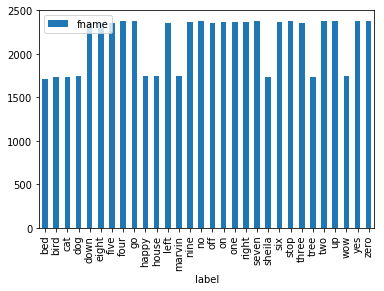

In [4]:
label_DF.groupby('label').agg('count').plot(kind='bar')
plt.show()

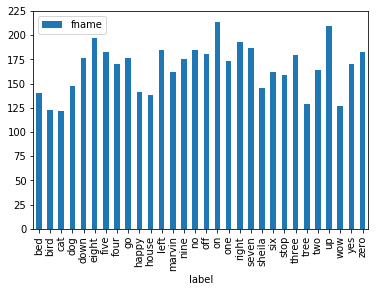

In [5]:
sampled_DF = label_DF.sample(5000).reset_index()
sampled_DF.groupby('label').agg('count').plot(kind='bar')
plt.show()

In [13]:
sampled_DF.fname = sampled_DF.fname.apply(lambda x: x.split('.')[0])
sampled_DF = sampled_DF[['fname','label']]
sampled_DF['label_norm'] = sampled_DF['label']

In [15]:
# create subset of data
dirname = '../data/gspeech-sample/'
sourcedir = '../data/google-speech-commands/'
destdir = os.path.join(dirname,'wavs') 

# copy files over
os.mkdir(destdir)
for index,row in sampled_DF.iterrows():
    print(index),
    fname,label = row['fname']+'.wav',row['label']
    os.system("cp {} {}".format(os.path.join(sourcedir,label,fname),
                                os.path.join(destdir,fname)))
    sys.stdout.flush()
# write out label csv file
sampled_DF.to_csv(os.path.join(dirname,'metadata.csv'),index=False,header=False,sep='|')

FileExistsError: [Errno 17] File exists: '../data/gspeech-sample/wavs'